# Red neuronal RNN
### Introducción y objetivo
## Descripción del problema a resolver
Se desea tener la capacidad de poder predecir el clima con respecto a datos anteriores, los cuales tomará en cuenta para la predicción de datos posteriores.

### Porqué la elección del dataset
Me parecio interesante poder predecir el clima o bien algun otro parámetro relacionado al mismo con base a data ya previamente establecida.

In [69]:
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import LabelEncoder

## Exploración de datos (EDA)
### Carga de dataset y visualización de los datos
Ahora, hacemos importación de los datos de entrenamiento y hacemos una impresion de las primeras 5 lineas solo para verificar vagemente el estado de lo mismos.

In [70]:
df = pd.read_csv("datasets/seattle-weather.csv")
df.head(5)

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


### Estadística descriptiva
Tambien encontramos cierta data informativa de los mismos. Vemos que el dataset completo es de 1461 y que tenemos 5 categorias en las cuales puede llegar a una predicción. cada una con su respectiva cantidad de datos. Cabe mencionar que a pesar de que en este caso no haya tanta variedad en cada una de las categorias, esta bien dado a que no es necesario una misma cantidad en cada uno.

In [71]:
def print_category_counts(df, column):
    counts = df[column].value_counts()
    print(f"Conteo de columna {column}:")
    print(counts)

print("Total de datos:", len(df))
print_category_counts(df, 'weather')

Total de datos: 1461
Conteo de columna weather:
weather
rain       641
sun        640
fog        101
drizzle     53
snow        26
Name: count, dtype: int64


### Identificación de desbalanceos o problemas
A grandes rasgos, creo que la cantidad de datos será suficiente para hacer un modelo suficiente bien, pero es de verificar si esto es cierto.

## Preprocesamiento
### Limpieza de datos
Ahora procedemos a hacer una limpieza de datos, pero haciendo una verificación de los mismos, podemos observar que no hay valores nulos ni valores repetidos, por lo que creo que la data está suficientemente limpia como para proceder con la misma.

In [72]:
print("Cantidad de valores nulos")
print(df.isnull().sum())
print("Cantidad repetidos")
print(df.duplicated().sum())

Cantidad de valores nulos
date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64
Cantidad repetidos
0


### Normalizacion
Ahora procedemos a definir la variable de salida, que en nuestro caso será la columna weather.

In [73]:
x = df.drop('weather', axis=1)
y = df[['weather']]

Luego se realiza el proceso de normalización. Se aprecia que tenemos un campo de fecha, el cual tambien es posible normalizando, que consistiria en convertirlo en un dato numérico siempre entre 0 y 1. Y ahora teniendo los datos normalizados de la fecha, podemos descartar la coumna original de la fecha.

In [74]:
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day

scaler = MinMaxScaler()
df[['year', 'month', 'day']] = scaler.fit_transform(df[['year', 'month', 'day']])
x = df.drop("date", axis=1)
x.head(5)

,precipitation,temp_max,temp_min,wind,weather,year,month,day
0,0.0,12.8,5.0,4.7,drizzle,0.0,0.0,0.000000
1,10.9,10.6,2.8,4.5,rain,0.0,0.0,0.033333
2,0.8,11.7,7.2,2.3,rain,0.0,0.0,0.066667
3,20.3,12.2,5.6,4.7,rain,0.0,0.0,0.100000
4,1.3,8.9,2.8,6.1,rain,0.0,0.0,0.133333


Ahora procedemos a normalizar el resto de los datos

In [75]:
numeric_cols = ['precipitation', 'temp_max', 'temp_min', 'wind']
date_cols = ['year', 'month', 'day']

preprocessor = sklearn.compose.ColumnTransformer([
    ('num', sklearn.preprocessing.StandardScaler(), numeric_cols),
    ('date', 'passthrough', date_cols)
])

x_processed = preprocessor.fit_transform(x)

### División de train y test data
Ahora, con la data transformada, establecemos la data que sera para testing y la data que sera para entrenamiento. Se establece que se la data de train sera del 80%, la data de test de un 10% y la data de validacion el restante 10%. Esto se ve en el parámetro test_size=0.1. y con la segunda ejecucion con el restante de valores.

In [76]:
le = LabelEncoder()
y = le.fit_transform(df['weather'])  

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_processed, y, test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(x_train, y_train, test_size=0.1111, random_state=42)

Por último se necesitamos hacer un reshaping para que tensorflow pueda procesar nuestra información

In [77]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[-1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[-1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[-1], 1))
# x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
# x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
# x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

## Definición de modelo
La arquitectura utilizada es una red neuronal recurrente (RNN) basada en LSTM, diseñada para capturar patrones temporales en datos secuenciales de clima. El modelo está compuesto por:

- Capa de entrada la cual recibe secuencias de datos con la forma (timesteps, features).
- Se establecen 3 capas LSTM de 50 neuronas, y se setea el return_sequence=True para poder mentaner la sequencia completa. Lueago se agregar una capa de droput del 20% de las neuronas. Se hace 
- La capa de salida es una capa densa con una neurona, que entrega la predicción final.

In [78]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/home/jorge/Documents/dev/python/venvs/ml/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Entrenamiento
### Definición de loss function y optimizer y configuración de hiperparámetros

Ahora procedemos a entrenar el modelo y hacer las gráficas de los resultados obtenidos. Los parámetros utilzados son:
- Funcion de optimización: Adam
- Función de loss: mean_squared_error el cual es comun para task de regresión
- Learning rate: 0.01
- Epochs: 100
- Batch size: 64
- Validation split: 0.15

Con la información obtenida del entrenamiento, se obtiene la información para poder hacer el guardado del mismo. Se agregaron funciones de checkpoint para que pueda seleccionar el mejor modelo y no el ultimo y una funcion de early stop para que pueda detenerse cuando la mejora en el valor del resultado de la funcion loss sera práctimente nula.

In [79]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='checkpoints/best_model.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mean_squared_error',
    metrics=['accuracy'])

y_train = y_train.astype(float)
y_val = y_val.astype(float)
y_test = y_test.astype(float)


history=model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint, early_stop])

model.load_weights("checkpoints/best_model.weights.h5")
model.save('mpl_model.keras')

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0360 - loss: 8.9248 - val_accuracy: 0.0342 - val_loss: 8.0395
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0360 - loss: 8.3547 - val_accuracy: 0.0342 - val_loss: 7.1678
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0428 - loss: 6.6386 - val_accuracy: 0.0959 - val_loss: 4.4371
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0659 - loss: 2.8625 - val_accuracy: 0.0890 - val_loss: 2.0346
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0659 - loss: 1.6168 - val_accuracy: 0.0890 - val_loss: 1.5186
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0659 - loss: 1.4847 - val_accuracy: 0.0890 - val_loss: 1.4463
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0659 - loss: 1.4782 - val_accuracy: 0.0890 - val_loss: 1.4433
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0659 - loss: 1.4908 - val_accuracy: 0.0890 - 

## Evaluación y Resultados
### Métricas en conjunto de test
Ahora procesdemos a graficar y verificar la información obtenida. Los resultados finales fueron:
- Acuaracy: 84.28%
- Loss: 34.80

In [80]:
model.evaluate(x_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0748 - loss: 1.4182 


[1.418172001838684, 0.07482992857694626]

### Visualizacion de curvas de aprendizaje

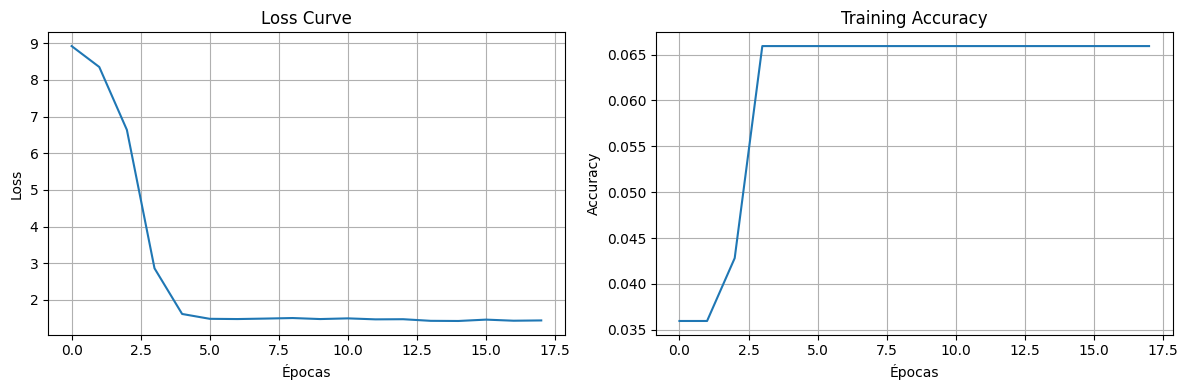

In [81]:
plt.figure(figsize=(12, 4))

# Graficar loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title("Loss Curve")
plt.xlabel("Épocas")
plt.ylabel("Loss")
plt.grid()

# Graficar accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.title("Training Accuracy")
plt.xlabel("Épocas")
plt.ylabel("Accuracy")
plt.grid()

plt.tight_layout()
plt.show()

### Matriz de confusión

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


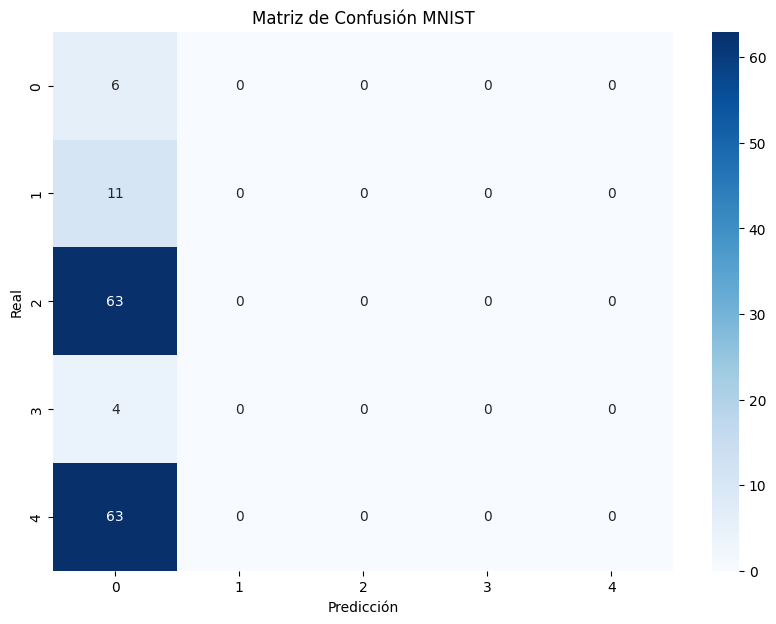

In [82]:
y_pred = model.predict(x_test)
y_pred_labels = y_pred.argmax(axis=1)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_labels)

# Graficar
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión MNIST")
plt.show()

### Ejemplos de predicción
Ahora para hacer una pruebas realista, se creara un ejemplo de una persona ficticia, con información necesaria para poder realizar una predicción de un dato nuevo para el modelo.

In [87]:
# Example: new_data is a 2D array with shape (1, num_features)
# Replace ... with your actual feature values
test = pd.DataFrame({
    "precipitation": [0],
    "temp_max": [10.6],
    "temp_min": [5],
    "wind": [4.7],
    "year": [0.5],
    "day": [0.33],
    "month": [0.22],
})

# Use the DataFrame you created
new_data_processed = preprocessor.transform(test)

# Reshape for the RNN: (samples, timesteps, features)
new_data_processed = new_data_processed.reshape((1, new_data_processed.shape[1], 1))

# Predict
prediction = model.predict(new_data_processed)

# Decode the label (if classification)
predicted_label = le.inverse_transform([int(prediction.round())])
print("Predicted label:", predicted_label[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted label: snow


/tmp/ipykernel_21482/3320056774.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = le.inverse_transform([int(prediction.round())])


## Análisis y conclusiones